# EECS 442 FINAL: Geoguessr Neural Network

## Setup

In [1]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import math

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
Mount the cwd to drive, access the train folder and load the images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install gitpython > /dev/null 2>&1
# !apt-get install -y -qq git > /dev/null 2>&1

import os
import glob
import random
from PIL import Image


# print(os.getcwd())
# ! ls
# ! cd drive/MyDrive/442final
# print(os.getcwd())

data_directory = "/drive/MyDrive/442final/train/resized_countries"

batch_size = 32
img_width = 148
img_height = 64
epochs = 30

img_target_scale = 0.2
img_target_width = int(math.floor(img_width * img_target_scale))
img_target_height= int(math.floor(img_height * img_target_scale))

class get_Images(Dataset):
  def __init__(self, root_dir, split='train', percentage=0.7, transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """
    self.files = []
    self.labels = []

    # if split=='val':
    #   percentage = 1 - percentage

    self.transform = transform
    print(root_dir)
    for idx, country in enumerate(os.listdir(root_dir)):
      print(idx, end=' ')
      # Check if the item is a directory
      files_in_dir = np.load(root_dir+'/'+country).astype(np.float32)
      files_in_dir = np.moveaxis(files_in_dir, [1, 2, 3], [2, 3, 1])
      # print(files_in_dir.dtype)
      # Randomly sample a certain percentage of files
      num_files_to_take = int(len(files_in_dir) * percentage)
      # Append the sampled file paths to the list
      if split=='train':
        self.files.extend(files_in_dir[:num_files_to_take])
      else:
        num_files = len(files_in_dir)
        self.files.extend(files_in_dir[num_files - num_files_to_take:])

      # self.files.extend(glob.glob(os.path.join(root_dir, country, '*.jpg')))
      self.labels.extend([idx] * num_files_to_take)
    print()
    print(len(self.files))
    print(len(self.labels))
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    # img_path = self.files[idx]
    label = self.labels[idx]
    # img = Image.open(img_path)
    # if self.transform:
    #     img = self.transform(img)
    return {'image': self.files[idx], 'label': label}

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

###########################################################################
# TODO: Construct the dataloader                                          #
# For the train_loader, please use a batch size of 4 and set shuffle True #
# For the val_loader, please use a batch size of 5 and set shuffle False  #
# Hint: You'll need to create instances of the class above, name them as  #
# tr_dt and te_dt. The dataloaders should be named as train_loader and    #
# test_loader. You also need to include transform in your class           #
#instances                                                                #
###########################################################################

tr_dt = get_Images(os.getcwd() + data_directory, split='train', percentage=0.7,  transform=transform)
te_dt = get_Images(os.getcwd() + data_directory, split='val', percentage=0.2, transform=transform)

train_loader = DataLoader(tr_dt, batch_size=32, shuffle=True)
test_loader = DataLoader(te_dt, batch_size=32, shuffle=False)

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

print("Done!")

Mounted at /content/drive
/content/drive/MyDrive/442final/train/resized_countries
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
25160
25160
/content/drive/MyDrive/442final/train/resized_countries
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
7171
7171
Number of training images 25160, number of testing images 7171
Done!


## Model
CHANGE THIS TO GET THE MODEL TO RUN

In [20]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        ##############################################################################
        # TODO: Design your own network, define layers here.                          #
        # Here We provide a sample of two-layer fc network from HW4 Part3.           #
        # Your solution, however, should contain convolutional layers.               #
        # Refer to PyTorch documentations of torch.nn to pick your layers.           #
        # (https://pytorch.org/docs/stable/nn.html)                                  #
        # Some common choices: Linear, Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout   #
        # If you have many layers, use nn.Sequential() to simplify your code         #
        ##############################################################################
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 8, 5, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 5, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4800, 55),  # Adjust the input size according to your desired dimensions
            nn.ReLU(),
          )
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        # TODO: Design your own network, implement forward pass here                 #
        ##############################################################################
        x = self.conv_relu_stack(x)
        return x
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (3, 148,64), device=device)) # visualize your model

##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
# Set up optimization hyperparameters
learning_rate, weight_decay, num_epoch = 0.001, 0.0001, 50
optimizer = optim.Adam(model.parameters(), learning_rate)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 146, 62]             608
              ReLU-2           [-1, 8, 146, 62]               0
            Conv2d-3            [-1, 8, 72, 30]           1,608
              ReLU-4            [-1, 8, 72, 30]               0
            Conv2d-5           [-1, 16, 70, 28]           3,216
              ReLU-6           [-1, 16, 70, 28]               0
            Conv2d-7           [-1, 16, 34, 13]           6,416
              ReLU-8           [-1, 16, 34, 13]               0
            Conv2d-9           [-1, 32, 32, 11]          12,832
             ReLU-10           [-1, 32, 32, 11]               0
           Conv2d-11            [-1, 64, 15, 5]          51,264
             ReLU-12            [-1, 64, 15, 5]               0
          Flatten-13                 [-1, 4800]               0
           Linear-14     

Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [ ]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        # print(len(tqdm(trainloader)))
        # for i in tqdm(trainloader):
        #   print(i)
        for input in tqdm(trainloader):
            # print(batch, label)
            # print(batch)
            batch, label = input['image'], input['label']
            # print(batch)
            # print(label)
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for input in tqdm(loader):
            batch, label = input['image'], input['label']
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader,
                                                  test_loader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
# evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 787/787 [00:06<00:00, 125.48it/s]



 Epoch 1 loss:3.7494030301725396


100%|██████████| 787/787 [00:03<00:00, 249.80it/s]



 Evaluation accuracy: 0.11705087440381558

 Evaluate on validation set...


100%|██████████| 225/225 [00:01<00:00, 220.10it/s]



 Evaluation accuracy: 0.11755682610514573
-----------------Epoch = 2-----------------


100%|██████████| 787/787 [00:06<00:00, 126.19it/s]



 Epoch 2 loss:3.7107370887354034


100%|██████████| 787/787 [00:03<00:00, 257.81it/s]



 Evaluation accuracy: 0.12810015898251192

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 260.47it/s]



 Evaluation accuracy: 0.12480825547343467
-----------------Epoch = 3-----------------


100%|██████████| 787/787 [00:06<00:00, 125.71it/s]



 Epoch 3 loss:3.6964527306441584


100%|██████████| 787/787 [00:03<00:00, 258.87it/s]



 Evaluation accuracy: 0.13437996820349762

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 256.69it/s]



 Evaluation accuracy: 0.13261748710082275
-----------------Epoch = 4-----------------


100%|██████████| 787/787 [00:06<00:00, 125.36it/s]



 Epoch 4 loss:3.6808766949131346


100%|██████████| 787/787 [00:03<00:00, 246.20it/s]



 Evaluation accuracy: 0.15258346581875995

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 258.05it/s]



 Evaluation accuracy: 0.1398689164691117
-----------------Epoch = 5-----------------


100%|██████████| 787/787 [00:06<00:00, 127.07it/s]



 Epoch 5 loss:3.667354873962596


100%|██████████| 787/787 [00:03<00:00, 224.43it/s]



 Evaluation accuracy: 0.1647456279809221

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 258.93it/s]



 Evaluation accuracy: 0.1454469390601032
-----------------Epoch = 6-----------------


100%|██████████| 787/787 [00:06<00:00, 126.33it/s]



 Epoch 6 loss:3.6513227843874745


100%|██████████| 787/787 [00:03<00:00, 250.25it/s]



 Evaluation accuracy: 0.13867249602543721

 Evaluate on validation set...


100%|██████████| 225/225 [00:01<00:00, 222.95it/s]



 Evaluation accuracy: 0.12048528796541626
-----------------Epoch = 7-----------------


100%|██████████| 787/787 [00:06<00:00, 119.37it/s]



 Epoch 7 loss:3.630119729375294


100%|██████████| 787/787 [00:03<00:00, 226.78it/s]



 Evaluation accuracy: 0.19002384737678854

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 252.90it/s]



 Evaluation accuracy: 0.14600474131920235
-----------------Epoch = 8-----------------


100%|██████████| 787/787 [00:06<00:00, 120.81it/s]



 Epoch 8 loss:3.5972381680257137


100%|██████████| 787/787 [00:03<00:00, 255.10it/s]



 Evaluation accuracy: 0.17118441971383147

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 256.92it/s]



 Evaluation accuracy: 0.13261748710082275
-----------------Epoch = 9-----------------


100%|██████████| 787/787 [00:06<00:00, 122.18it/s]



 Epoch 9 loss:3.5505917469155532


100%|██████████| 787/787 [00:03<00:00, 245.16it/s]



 Evaluation accuracy: 0.23302861685214626

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 246.33it/s]



 Evaluation accuracy: 0.14335518058848137
-----------------Epoch = 10-----------------


100%|██████████| 787/787 [00:06<00:00, 124.00it/s]



 Epoch 10 loss:3.4835345778410742


100%|██████████| 787/787 [00:03<00:00, 215.93it/s]



 Evaluation accuracy: 0.2435214626391097

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 243.75it/s]



 Evaluation accuracy: 0.14126342211685958
-----------------Epoch = 11-----------------


100%|██████████| 787/787 [00:06<00:00, 124.92it/s]



 Epoch 11 loss:3.4064481930932673


100%|██████████| 787/787 [00:03<00:00, 229.09it/s]



 Evaluation accuracy: 0.26593799682034974

 Evaluate on validation set...


100%|██████████| 225/225 [00:01<00:00, 210.93it/s]



 Evaluation accuracy: 0.13289638823037234
-----------------Epoch = 12-----------------


100%|██████████| 787/787 [00:06<00:00, 125.60it/s]



 Epoch 12 loss:3.340504354261231


100%|██████████| 787/787 [00:03<00:00, 246.30it/s]



 Evaluation accuracy: 0.26017488076311607

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 231.44it/s]



 Evaluation accuracy: 0.1243899037791103
-----------------Epoch = 13-----------------


100%|██████████| 787/787 [00:06<00:00, 122.20it/s]



 Epoch 13 loss:3.2543545314590085


100%|██████████| 787/787 [00:03<00:00, 245.40it/s]



 Evaluation accuracy: 0.27456279809220985

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 244.69it/s]



 Evaluation accuracy: 0.11936968344721796
-----------------Epoch = 14-----------------


100%|██████████| 787/787 [00:06<00:00, 121.64it/s]



 Epoch 14 loss:3.1772730074813436


100%|██████████| 787/787 [00:03<00:00, 251.25it/s]



 Evaluation accuracy: 0.29630365659777425

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 247.48it/s]



 Evaluation accuracy: 0.11950913401199274
-----------------Epoch = 15-----------------


100%|██████████| 787/787 [00:06<00:00, 123.12it/s]



 Epoch 15 loss:3.10988328235728


100%|██████████| 787/787 [00:03<00:00, 235.04it/s]



 Evaluation accuracy: 0.3

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 249.90it/s]



 Evaluation accuracy: 0.11337330916190211
-----------------Epoch = 16-----------------


100%|██████████| 787/787 [00:06<00:00, 124.32it/s]



 Epoch 16 loss:3.057640771853727


100%|██████████| 787/787 [00:03<00:00, 218.67it/s]



 Evaluation accuracy: 0.30635930047694754

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 247.87it/s]



 Evaluation accuracy: 0.11058429786640636
-----------------Epoch = 17-----------------


100%|██████████| 787/787 [00:06<00:00, 125.69it/s]



 Epoch 17 loss:3.028969027793089


100%|██████████| 787/787 [00:03<00:00, 241.26it/s]



 Evaluation accuracy: 0.30798887122416535

 Evaluate on validation set...


100%|██████████| 225/225 [00:01<00:00, 215.18it/s]



 Evaluation accuracy: 0.0978942964719007
-----------------Epoch = 18-----------------


100%|██████████| 787/787 [00:06<00:00, 124.53it/s]



 Epoch 18 loss:3.028663411982632


100%|██████████| 787/787 [00:03<00:00, 244.86it/s]



 Evaluation accuracy: 0.3109300476947536

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 244.97it/s]



 Evaluation accuracy: 0.10068330776739645
-----------------Epoch = 19-----------------


100%|██████████| 787/787 [00:06<00:00, 122.77it/s]



 Epoch 19 loss:2.9757178059981464


100%|██████████| 787/787 [00:03<00:00, 245.97it/s]



 Evaluation accuracy: 0.3106518282988871

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 247.12it/s]



 Evaluation accuracy: 0.09203737275135965
-----------------Epoch = 20-----------------


100%|██████████| 787/787 [00:06<00:00, 123.97it/s]



 Epoch 20 loss:2.9608191018486267


100%|██████████| 787/787 [00:03<00:00, 248.24it/s]



 Evaluation accuracy: 0.3107710651828299

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 249.86it/s]



 Evaluation accuracy: 0.08297308604099847
-----------------Epoch = 21-----------------


100%|██████████| 787/787 [00:06<00:00, 125.82it/s]



 Epoch 21 loss:2.96664474789039


100%|██████████| 787/787 [00:03<00:00, 220.71it/s]



 Evaluation accuracy: 0.3082273449920509

 Evaluate on validation set...


100%|██████████| 225/225 [00:00<00:00, 249.84it/s]



 Evaluation accuracy: 0.08618044903081858
-----------------Epoch = 22-----------------


 51%|█████     | 403/787 [00:03<00:03, 125.61it/s]

Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

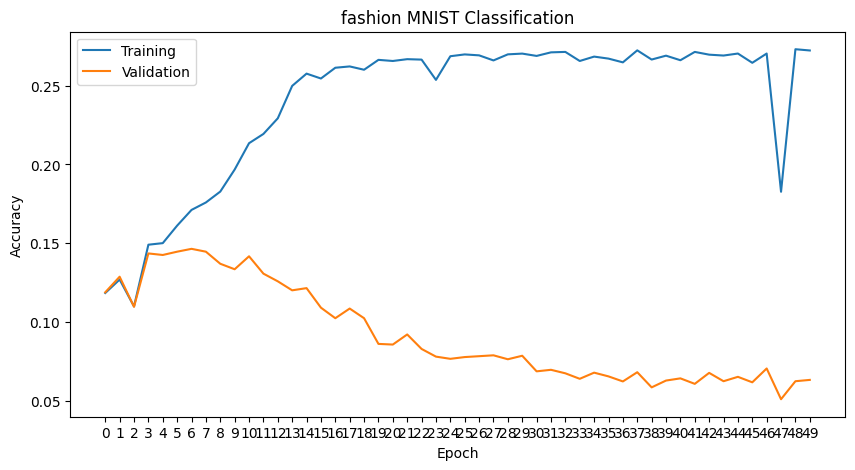

In [17]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()